<a href="https://colab.research.google.com/github/CarolinaR99/Projeto1_ADAR/blob/main/Projecto_ADDAR_Sleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Parse EDF and .txt with annotations to a CSV file 

In [6]:
#@title
import os
import numpy as np
import pandas as pd
import urllib.request
from datetime import datetime
!pip install mne
import mne

def to_timestamp(x: str, acq_time: datetime):
    date = datetime.strptime(x, '%H:%M:%S')
    date = datetime(acq_time.year, acq_time.month, acq_time.day, date.hour, date.minute, date.second)
    if date.hour < 12:
        date = datetime(date.year, date.month, date.day + 1, date.hour, date.minute, date.second)
    return (date.day - acq_time.day) * 24 * 3600 + (date.hour - acq_time.hour) * 3600 + (
                date.minute - acq_time.minute) * 60 + date.second - acq_time.second


def subsample(data: np.ndarray, fs: int, fs_new: int, axis=0):
    assert fs % fs_new == 0
    factor = int(fs / fs_new)
    if data.shape[axis] % factor != 0:
        print('Subsampling led to loss of %i samples, in an online setting consider using a BlockBuffer with a '
              'buffer size of a multiple of %i samples.' % (data.shape[axis] % factor, factor))
    idx_mask = np.arange(data.shape[axis], step=factor)
    return data.take(idx_mask, axis)


def read_annotation_file(path_filename: str, acq_time: datetime):
    df_annotations_data = pd.read_csv(path_filename, sep='\t', skiprows=20)
    df_annotations_data = df_annotations_data.loc[df_annotations_data["Event"].str.startswith("SLEEP")]
    df_annotations_data = df_annotations_data.rename(columns={"Time [hh:mm:ss]": "onset", "Duration[s]": "duration"})
    df_annotations_data["timestamp"] = df_annotations_data.onset.apply(lambda x: to_timestamp(x, acq_time))

    return df_annotations_data


def merge_data_file_and_annotations(data, df_annotations, fs_new):
    raw_data = data.get_data()
    fs = int(data.info["sfreq"])
    df = pd.DataFrame(raw_data.T, columns=data.info.ch_names)
    df["times"] = data.times
    df = pd.DataFrame(data=subsample(df.to_numpy(), fs, fs_new), columns=df.columns)
    
    labels = [np.nan] * df.shape[0]
    for i in range(df_annotations.shape[0] - 1):
        row_start = df_annotations.iloc[i]
        row_end = df_annotations.iloc[i + 1]
        start_pos = row_start.timestamp * fs_new
        end_pos = row_end.timestamp * fs_new
        if start_pos < len(labels):
            labels[start_pos:end_pos] = [row_start["Sleep Stage"]]*(end_pos-start_pos)
    
    df["sleepstage"] = labels
    df = df.dropna()
    
    return df


In [7]:
# Subject ID
subject_name = 'n1'
# New frequency
fs_new = 128
# CSV Filename
new_filename = f'{subject_name}_data_and_annotations.csv'
              
data_filename = f'{subject_name}.edf'
filename_annotations = f'{subject_name}_annotations.txt'
url_data = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.edf?download'
url_annotations = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.txt?download'

print(f'Downloading data file: {url_data}')
urllib.request.urlretrieve(url_data, data_filename)

print(f'Downloading annotations data file: {url_annotations}')
urllib.request.urlretrieve(url_annotations, filename_annotations)


print(f'Loading File: {data_filename}')
data_polysomnography = mne.io.read_raw_edf(data_filename)

print(f'Loading Annotations file: {filename_annotations}')
df_annotations_polysomnography = read_annotation_file(filename_annotations, data_polysomnography.info["meas_date"])

print("\n\n Example Annotations file: \n")
df_annotations_polysomnography.head(4)

Loading File: n1.edf
Extracting EDF parameters from /content/n1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Loading Annotations file: n1_annotations.txt


 Example Annotations file: 



,Sleep Stage,Position,onset,Event,duration,Location,timestamp
0,W,Unknown Position,22:09:33,SLEEP-S0,30,ROC-LOC,210
1,W,Unknown Position,22:10:03,SLEEP-S0,30,ROC-LOC,240
2,W,Unknown Position,22:10:33,SLEEP-S0,30,ROC-LOC,270
3,W,Unknown Position,22:11:03,SLEEP-S0,30,ROC-LOC,300


In [8]:
print(f'Merge files annotation and polysomnography data. Downsampling data from {data_polysomnography.info["sfreq"]} to {fs_new} Hz')
df_data = merge_data_file_and_annotations(data_polysomnography, df_annotations_polysomnography, fs_new)
df_data.to_csv(new_filename, index=False)
print("Data Merged")
df_data.head(4)

Merge files annotation and polysomnography data. Downsampling data from 512.0 to 128 Hz
Data Merged


,ROC-LOC,LOC-ROC,F2-F4,F4-C4,C4-P4,P4-O2,F1-F3,F3-C3,C3-P3,P3-O1,C4-A1,EMG1-EMG2,ECG1-ECG2,TERMISTORE,TORACE,ADDOME,Dx1-DX2,SX1-SX2,Posizione,HR,SpO2,times,sleepstage
26880,-2.625284e-06,2.625284e-06,-7.173382e-07,2.213065e-06,2.335165e-06,3.510379e-07,-0.000005,6.517094e-06,7.463370e-06,1.358364e-06,0.000018,0.000004,0.000046,-0.000059,0.000111,-0.000360,2.899347e-07,-7.172069e-07,3.0,75.083543,95.017929,210.000000,W
26881,-4.578984e-07,4.578984e-07,-1.297314e-06,1.633089e-06,2.594628e-07,-1.068376e-07,-0.000007,3.952991e-06,6.364469e-06,1.785714e-06,0.000019,-0.000006,0.000046,-0.000052,0.000094,-0.000317,2.899347e-07,2.288958e-07,3.0,75.083543,95.017929,210.007812,W
26882,-4.884249e-07,4.884249e-07,-1.678877e-07,-4.578755e-08,-2.274115e-06,-1.297314e-06,-0.000005,4.731380e-07,2.090965e-06,3.815629e-07,0.000018,0.000012,0.000048,-0.000061,0.000118,-0.000378,-1.525972e-08,-4.730513e-07,3.0,75.083543,95.017929,210.015625,W
26883,-3.846346e-06,3.846346e-06,1.205739e-06,-1.144689e-06,-2.762515e-06,-1.572039e-06,-0.000003,-6.257631e-07,6.257631e-07,-4.731380e-07,0.000017,0.000007,0.000044,-0.000066,0.000132,-0.000415,-1.373375e-07,-4.577916e-08,3.0,75.083543,95.017929,210.023438,W


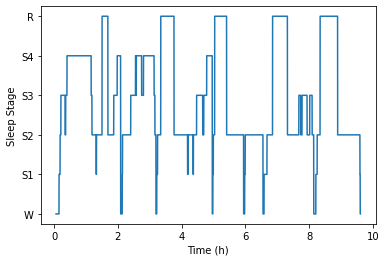

In [9]:
import matplotlib.pyplot as plt
_ = plt.plot(df_data.times/3600, df_data.sleepstage)
_ = plt.xlabel("Time (h)")
_ = plt.ylabel("Sleep Stage")

## Load CSV

In [15]:
import os
import numpy as np
import pandas as pd
import urllib.request
from datetime import datetime
import mne

df = pd.read_csv(new_filename)
df.head(4)

,ROC-LOC,LOC-ROC,F2-F4,F4-C4,C4-P4,P4-O2,F1-F3,F3-C3,C3-P3,P3-O1,C4-A1,EMG1-EMG2,ECG1-ECG2,TERMISTORE,TORACE,ADDOME,Dx1-DX2,SX1-SX2,Posizione,HR,SpO2,times,sleepstage
0,-2.625284e-06,2.625284e-06,-7.173382e-07,2.213065e-06,2.335165e-06,3.510379e-07,-0.000005,6.517094e-06,7.463370e-06,1.358364e-06,0.000018,0.000004,0.000046,-0.000059,0.000111,-0.000360,2.899347e-07,-7.172069e-07,3.0,75.083543,95.017929,210.000000,W
1,-4.578984e-07,4.578984e-07,-1.297314e-06,1.633089e-06,2.594628e-07,-1.068376e-07,-0.000007,3.952991e-06,6.364469e-06,1.785714e-06,0.000019,-0.000006,0.000046,-0.000052,0.000094,-0.000317,2.899347e-07,2.288958e-07,3.0,75.083543,95.017929,210.007812,W
2,-4.884249e-07,4.884249e-07,-1.678877e-07,-4.578755e-08,-2.274115e-06,-1.297314e-06,-0.000005,4.731380e-07,2.090965e-06,3.815629e-07,0.000018,0.000012,0.000048,-0.000061,0.000118,-0.000378,-1.525972e-08,-4.730513e-07,3.0,75.083543,95.017929,210.015625,W
3,-3.846346e-06,3.846346e-06,1.205739e-06,-1.144689e-06,-2.762515e-06,-1.572039e-06,-0.000003,-6.257631e-07,6.257631e-07,-4.731380e-07,0.000017,0.000007,0.000044,-0.000066,0.000132,-0.000415,-1.373375e-07,-4.577916e-08,3.0,75.083543,95.017929,210.023438,W


In [ ]:
#df.head(4)

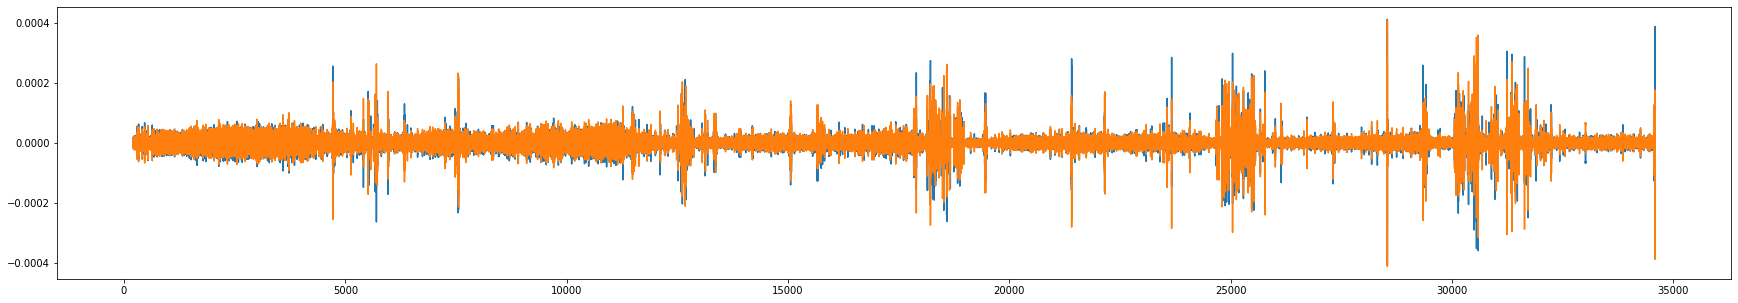

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize = (30,5))
plt.plot(df["times"], df["ROC-LOC"])
plt.plot(df["times"], df["LOC-ROC"])
#plt.plot(df["times"], df["sleepstage"])

In [17]:
#sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


new_df = df.iloc[:,:-2]
new_df.head(4)
print(scaler.fit(new_df))

print(scaler.data_max_)
df_norm = scaler.transform(new_df)
df_norm = pd.DataFrame(df_norm)
df_norm['times'] = df['times']
df_norm['sleepstage'] = df['sleepstage']
df_norm.head(4)

MinMaxScaler(copy=True, feature_range=(0, 1))
[4.11223246e-04 4.07590586e-04 5.60332723e-04 3.62652625e-04
 3.93177656e-04 1.00022894e-03 5.52335165e-04 3.11034799e-04
 6.67170330e-04 5.70985958e-04 3.89819902e-04 1.72758489e-04
 5.75215162e-04 2.59030316e-04 6.35172827e-03 6.36161123e-03
 8.26878472e-04 8.34691448e-04 3.00000000e+00 9.00679026e+01
 9.90218967e+01]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,times,sleepstage
0,0.494576,0.505424,0.342891,0.501856,0.598709,0.381495,0.569009,0.641009,0.540942,0.497184,0.580808,0.574908,0.512473,0.384376,0.509000,0.471837,0.534943,0.530126,0.0,0.833446,0.959544,210.000000,W
1,0.497223,0.502777,0.342212,0.501055,0.596578,0.381212,0.568089,0.637986,0.540177,0.497562,0.581359,0.548705,0.512360,0.397430,0.507660,0.475217,0.534943,0.530658,0.0,0.833446,0.959544,210.007812,W
2,0.497185,0.502815,0.343534,0.498734,0.593976,0.380476,0.569552,0.633884,0.537203,0.496322,0.580808,0.593249,0.514020,0.380598,0.509504,0.470422,0.534771,0.530263,0.0,0.833446,0.959544,210.015625,W
3,0.493084,0.506916,0.345143,0.497216,0.593475,0.380306,0.570943,0.632588,0.536184,0.495568,0.579913,0.581843,0.510139,0.370515,0.510627,0.467503,0.534702,0.530503,0.0,0.833446,0.959544,210.023438,W


In [18]:
df_norm.columns = df.columns 

df_sel = df_norm[["F2-F4","F4-C4","C4-P4","P4-O2","F1-F3","F3-C3","C3-P3","P3-O1","C4-A1","ECG1-ECG2","EMG1-EMG2","times","sleepstage"]]
df.head(4)

,ROC-LOC,LOC-ROC,F2-F4,F4-C4,C4-P4,P4-O2,F1-F3,F3-C3,C3-P3,P3-O1,C4-A1,EMG1-EMG2,ECG1-ECG2,TERMISTORE,TORACE,ADDOME,Dx1-DX2,SX1-SX2,Posizione,HR,SpO2,times,sleepstage
0,-2.625284e-06,2.625284e-06,-7.173382e-07,2.213065e-06,2.335165e-06,3.510379e-07,-0.000005,6.517094e-06,7.463370e-06,1.358364e-06,0.000018,0.000004,0.000046,-0.000059,0.000111,-0.000360,2.899347e-07,-7.172069e-07,3.0,75.083543,95.017929,210.000000,W
1,-4.578984e-07,4.578984e-07,-1.297314e-06,1.633089e-06,2.594628e-07,-1.068376e-07,-0.000007,3.952991e-06,6.364469e-06,1.785714e-06,0.000019,-0.000006,0.000046,-0.000052,0.000094,-0.000317,2.899347e-07,2.288958e-07,3.0,75.083543,95.017929,210.007812,W
2,-4.884249e-07,4.884249e-07,-1.678877e-07,-4.578755e-08,-2.274115e-06,-1.297314e-06,-0.000005,4.731380e-07,2.090965e-06,3.815629e-07,0.000018,0.000012,0.000048,-0.000061,0.000118,-0.000378,-1.525972e-08,-4.730513e-07,3.0,75.083543,95.017929,210.015625,W
3,-3.846346e-06,3.846346e-06,1.205739e-06,-1.144689e-06,-2.762515e-06,-1.572039e-06,-0.000003,-6.257631e-07,6.257631e-07,-4.731380e-07,0.000017,0.000007,0.000044,-0.000066,0.000132,-0.000415,-1.373375e-07,-4.577916e-08,3.0,75.083543,95.017929,210.023438,W


In [19]:
columns_electrodes = [el for el in df_sel.columns if el not in ["times", "sleepstage"]]
columns_electrodes

['F2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'F1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'C4-A1',
 'ECG1-ECG2',
 'EMG1-EMG2']

In [20]:
# Conversion sleep stages to Id's
sleep_stages_ids = {"W": 0, "S1": 1, "S2": 2, "S3":3, "S4":3, "R": 4}
sleep_stages_parsed = df["sleepstage"].apply(lambda x: sleep_stages_ids[x])

# Convert the sleep stage to ID's
df_sel["sleepstage"] = sleep_stages_parsed

df_sel.head(4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,F2-F4,F4-C4,C4-P4,P4-O2,F1-F3,F3-C3,C3-P3,P3-O1,C4-A1,ECG1-ECG2,EMG1-EMG2,times,sleepstage
0,0.342891,0.501856,0.598709,0.381495,0.569009,0.641009,0.540942,0.497184,0.580808,0.512473,0.574908,210.000000,0
1,0.342212,0.501055,0.596578,0.381212,0.568089,0.637986,0.540177,0.497562,0.581359,0.512360,0.548705,210.007812,0
2,0.343534,0.498734,0.593976,0.380476,0.569552,0.633884,0.537203,0.496322,0.580808,0.514020,0.593249,210.015625,0
3,0.345143,0.497216,0.593475,0.380306,0.570943,0.632588,0.536184,0.495568,0.579913,0.510139,0.581843,210.023438,0


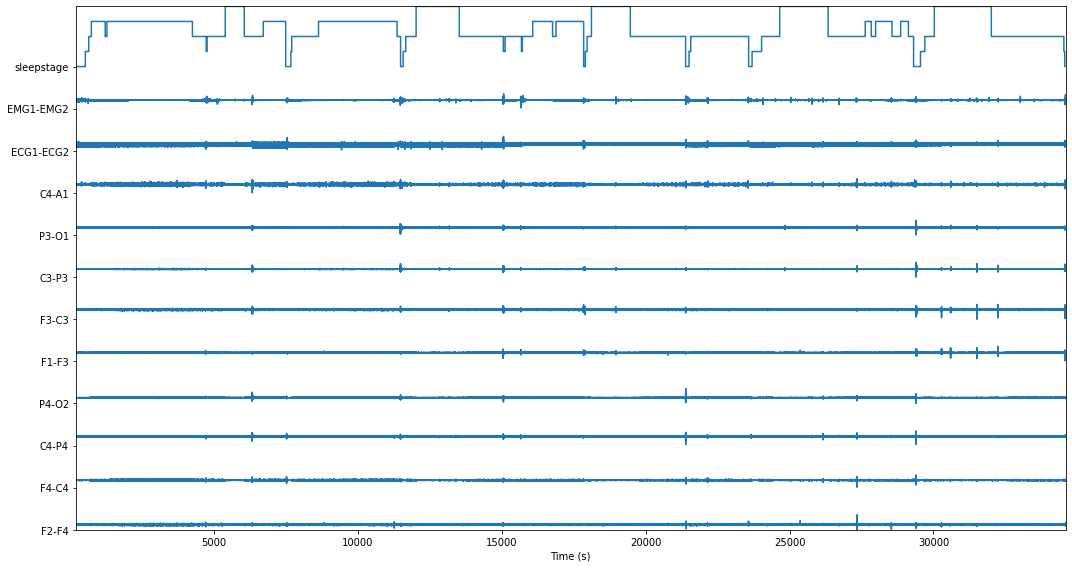

In [21]:
fs = int(1/(df_sel.times[1] - df_sel.times[0]))

# Number of points to plot per second, in this case all the points are being ploted
number_points_1_sec = 10/fs
marker_every_sec = int(number_points_1_sec*fs)
indexes_plot = np.arange(0, df.shape[0], marker_every_sec)

def plot_multiple(df_data, columns_plot, ax2, markevery=1):
  """
  This function receives a dataframe, the column names that one desires to plot 
  and the Axes plot
  """

  plt_columns = columns_plot.copy()
  # Plot also sleep stage
  plt_columns.append("sleepstage")

  n_rows = len(plt_columns)
  dmin = df_data[plt_columns].min().min()
  dmax = df_data[plt_columns].max().max()
  dr = (dmax - dmin) * 0.7  # Crowd them a bit.
  y0 = dmin
  y1 = (n_rows - 1) * dr + dmax
  ax2.set_ylim(y0, y1)
  ticklocs=[]
  segs = []
  ax2.set_xlim([df_data.times.min(), df_data.times.max()])
  ax2.set_ylim(y0, y1)

  for i, column_name in enumerate(plt_columns):
      segs.append(df_data.iloc[np.arange(0, df_data.shape[0], markevery)][["times", column_name]])
      ticklocs.append(i * dr)
  

  offsets = np.zeros((n_rows, 2), dtype=float)
  offsets[:, 1] = ticklocs

  lines = LineCollection(segs, offsets=offsets, transOffset=None)
  ax2.add_collection(lines)

  # Set the yticks to use axes coordinates on the y axis
  _ = ax2.set_yticks(ticklocs)
  # Set the yticks to use axes coordinates on the y axis
  ax2.set_yticks(ticklocs)
  ax2.set_yticklabels(plt_columns)

  ax2.set_xlabel('Time (s)')
  
from matplotlib.collections import LineCollection

f, ax_multiple = plt.subplots(1, 1, figsize=(15, 8)) 
plot_multiple(df_sel, columns_electrodes, ax_multiple, markevery=marker_every_sec)

plt.tight_layout()
plt.show()

In [22]:
from sklearn.decomposition import FastICA
ica_model = FastICA(n_components=len(columns_electrodes), random_state=0)

# Apply ICA only to the electrodes (exclude sleep stages and times)
independent_sources = ica_model.fit_transform(df_sel[columns_electrodes])

# Apply the Min-Max Scaler
scaled_independent_sources = MinMaxScaler().fit_transform(independent_sources)*df_sel["sleepstage"].max()

# The fit_transform returns a matrix, convert it to dataframe
components_columns_name = [f'component#{el}' for el in range(len(columns_electrodes))]
print(components_columns_name)
df_sources = pd.DataFrame(data=scaled_independent_sources, columns=components_columns_name)
df_sources["times"] = df_sel["times"]
df_sources["sleepstage"] = df_sel["sleepstage"]
df_sources.head(4)

['component#0', 'component#1', 'component#2', 'component#3', 'component#4', 'component#5', 'component#6', 'component#7', 'component#8', 'component#9', 'component#10']


,component#0,component#1,component#2,component#3,component#4,component#5,component#6,component#7,component#8,component#9,component#10,times,sleepstage
0,1.699761,1.726761,2.082935,2.275617,2.160126,2.266444,2.496606,2.412211,1.384830,2.414973,1.946472,210.000000,0
1,1.804552,1.729029,2.083329,2.285006,2.152762,2.264045,2.495242,2.408411,1.385407,2.407243,1.945471,210.007812,0
2,1.626377,1.734300,2.082573,2.309471,2.133978,2.268596,2.488709,2.409383,1.393893,2.404842,1.943972,210.015625,0
3,1.672091,1.733924,2.081985,2.314666,2.123535,2.272488,2.485441,2.410316,1.400929,2.407513,1.959036,210.023438,0


In [32]:
ica_model.mixing_
# Esta matriz dá-nos ideia dos sinais que contribuem para...

array([[-1.27645529e-02,  1.11136521e+01, -1.36772208e+00,
        -6.52259411e+00,  1.17302906e+01,  4.95071988e-01,
        -1.01583874e+00, -8.75040860e-02,  1.76370209e+01,
         1.46043312e+00,  9.59036135e-02],
       [ 4.98440329e-03,  1.10043608e+01, -1.51962071e+00,
        -3.53716026e+00,  2.00361330e+01, -1.18349090e-01,
        -1.30779506e+00, -9.08363105e-01, -2.13841921e+00,
         5.03012735e-01,  5.11909796e-01],
       [ 5.84778640e-03, -3.54950189e+00, -9.58770611e+00,
        -3.26653221e+00,  1.12431274e+01, -2.42480433e-01,
        -9.15616326e-01, -9.35205606e-01, -2.52901615e+00,
         9.25613661e+00,  4.08883846e-02],
       [-2.82711577e-03, -8.08713148e+00,  7.47497295e+00,
        -1.88013926e+00,  6.17322033e+00,  2.36119067e-01,
        -8.31234152e+00,  1.28178643e+00, -1.02998812e+00,
        -1.03045149e+00,  2.57130761e-01],
       [ 3.47401043e-03,  7.42409828e+00, -1.76660174e-01,
        -2.62349830e+00,  5.73363988e+00,  1.48956735e+01,
  

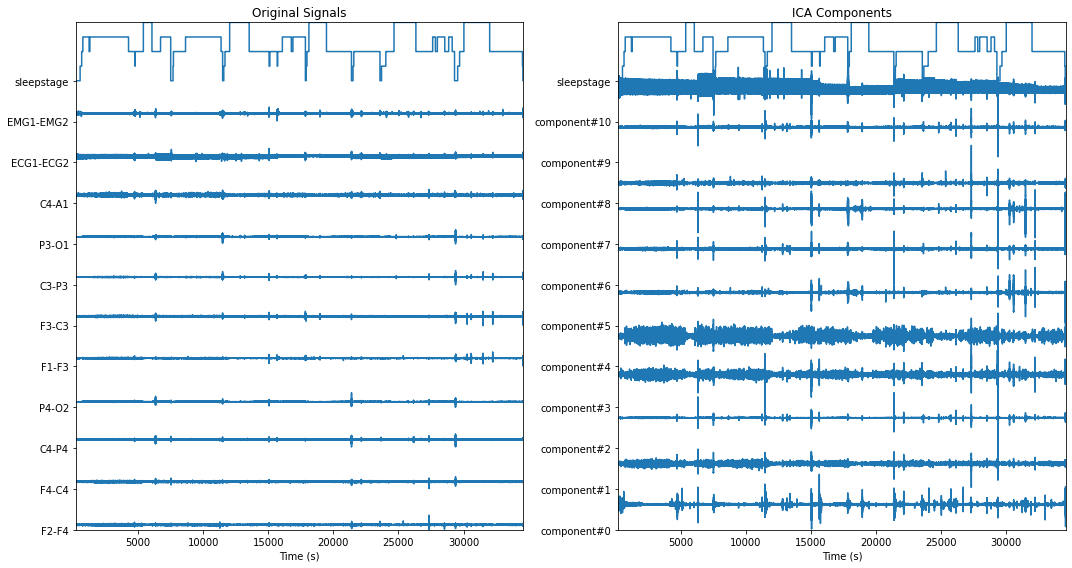

In [23]:
f, ax_ica = plt.subplots(1, 2, figsize=(15, 8)) 
plot_multiple(df_sel, columns_electrodes, ax_ica[0], markevery=marker_every_sec)
plot_multiple(df_sources, components_columns_name, ax_ica[1], markevery=marker_every_sec)
ax_ica[0].set_title("Original Signals")
ax_ica[1].set_title("ICA Components")
plt.tight_layout()
plt.show()

In [24]:
def remove_a_component(model_ica, df_indp_sources, index):

  df_sources_clean = df_indp_sources.copy()
  for i in index:
    df_sources_clean[df_sources.columns[i]] = 0

  # Times and sleep stages cannot be used in the reconstruction, therefore they should be removed 
  cols = [el for el in df_sources_clean.columns if el not in ["times", "sleepstage"]]
  X_restored = model_ica.inverse_transform(df_sources_clean[cols])
  X_restored_scaled = MinMaxScaler().fit_transform(X_restored)*df_indp_sources["sleepstage"].max()
  return  X_restored_scaled

def plot_with_wihout_component(model_ica, df_indp_sources, index, data_original):
  _ = plt.clf()
  print(f'Removing components {index}, this might take a few seconds.')
  columns_orig = [el for el in data_original.columns if el not in ["times", "sleepstage"]]
  sources_clean = remove_a_component(model_ica, df_indp_sources, index)
  df_sources_clean = pd.DataFrame(data=sources_clean, columns=columns_orig)

  df_sources_clean["times"] = data_original["times"]
  df_sources_clean["sleepstage"] = data_original["sleepstage"]

  f, ax_clean = plt.subplots(1, 3, figsize=(25, 15)) 
  plot_multiple(df_sel, columns_electrodes, ax_clean[0], markevery=marker_every_sec)
  plot_multiple(df_indp_sources, components_columns_name, ax_clean[1], markevery=marker_every_sec)
  plot_multiple(df_sources_clean, columns_electrodes, ax_clean[2], markevery=marker_every_sec)
  ax_clean[0].set_title("Original Signals")
  ax_clean[1].set_title("ICA Components")
  ax_clean[2].set_title("Cleaned Signals")
  _ = plt.tight_layout()
  plt.show()


Removing components [4, 10], this might take a few seconds.


<Figure size 432x288 with 0 Axes>

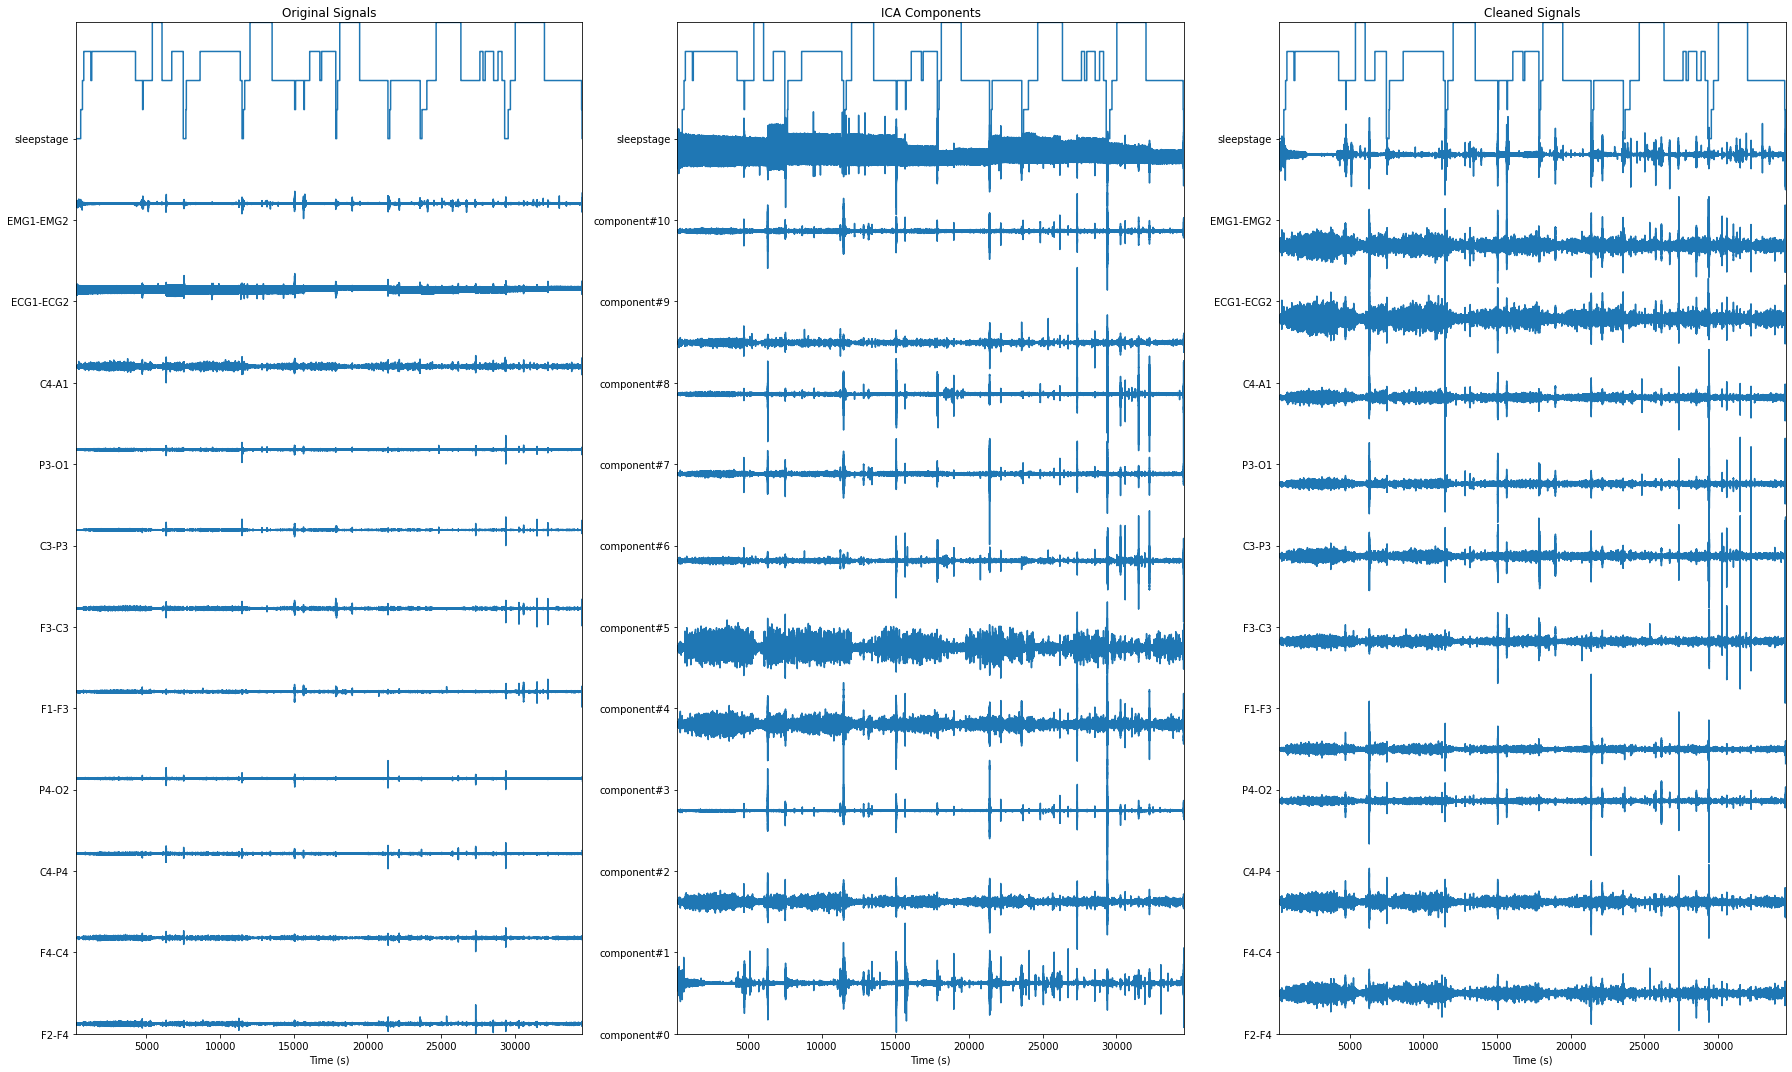

In [29]:
from ipywidgets import interact, fixed
plot_with_wihout_component(ica_model, df_sources, [4,10], data_original=df_sel)
#interact(plot_with_wihout_component, column_name_component_rejected=components_columns_name, model_ica=fixed(ica_model), df_indp_sources=fixed(df_sources), data_original=fixed(df_sel));